# Data Pre-processing



In [5]:
import os
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

In [6]:
# Get Data from Ceiba
url = 'https://ceiba.ntu.edu.tw/course/88ca22/content/training.txt'
content = requests.get(url).content
content = content.decode('utf-8')

data = {}
content = content.replace(' \r', '').replace(' ', ',').strip().split('\n')

for c in content:
    if c.startswith('13'):
        c = c[:-1]  # direct downloading has a weird " " at the end
    c = [int(x) for x in c.split(',')]
    data[ c[0] ] = c[1:]

In [7]:
# Fetch data from local (1095 files)
location = os.getcwd()+'/PA-1'

fnames = []
for i in range(1, 1096):
    fnames.append( str(i)+'.txt' )

documents = []
for filename in fnames:
    with open(os.path.join(location, filename), 'r') as f: # open in read-only mode
        # combine the text. (original text was split into lines)
        whole_paragraph = ''
        for line in f:
            whole_paragraph += ( line.strip()+' ' )
        
        documents.append( whole_paragraph )

assert len(documents) == 1095

In [8]:
vectorizer = CountVectorizer()
X_train_tf = vectorizer.fit_transform(documents)
assert X_train_tf.shape == (1095, 19422) # <class 'scipy.sparse.csr.csr_matrix'>

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf).toarray()

In [9]:
X_in = np.empty( (0,19422),float )
Y_in = np.array( [] )

OUT = []
for i in range(1,1096):
    OUT.append(True)

for label, x in data.items():
    for t in x:
        # print(t, X_train_tfidf[t-1].shape, X_train_tfidf[t-1])
        X_in = np.append(X_in, np.array([ X_train_tfidf[t-1] ]), axis=0)
        Y_in = np.append( Y_in, label )
        OUT[t-1] = False

print('In Sample (X & Y):', X_in.shape, Y_in.shape)

In Sample (X & Y): (195, 19422) (195,)


In [10]:
X_out = np.empty( (0,19422),float )
X_out_idx = []
for i in range(1,1096):
    if OUT[i-1]:
        X_out = np.append(X_out, np.array([ X_train_tfidf[i-1] ]), axis=0)
        X_out_idx.append(i)

print('Out of Sample (only X):', X_out.shape)

Out of Sample (only X): (900, 19422)


In [11]:
# split 195 data into train:175 / test:20 (10%)
X_train, X_test, y_train, y_test = train_test_split(X_in, Y_in, test_size=0.1, random_state = 46)

# Naive Bayes

In [27]:
bin_vectorizer = CountVectorizer(binary=True)
bin_vectors = bin_vectorizer.fit_transform(documents).toarray()

In [28]:
bin_vectors

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
bin_vectors.shape

(1095, 19422)

In [29]:
X_in = np.empty( (0,19422),float )
Y_in = np.array( [] )

OUT = []
for i in range(1,1096):
    OUT.append(True)

for label, x in data.items():
    for t in x:
        # print(t, X_train_tfidf[t-1].shape, X_train_tfidf[t-1])
        X_in = np.append(X_in, np.array([ bin_vectors[t-1] ]), axis=0)
        Y_in = np.append( Y_in, label )
        OUT[t-1] = False

print('In Sample (X & Y):', X_in.shape, Y_in.shape)

In Sample (X & Y): (195, 19422) (195,)


In [30]:
X_out = np.empty( (0,19422),float )
X_out_idx = []
for i in range(1,1096):
    if OUT[i-1]:
        X_out = np.append(X_out, np.array([ bin_vectors[i-1] ]), axis=0)
        X_out_idx.append(i)

print('Out of Sample (only X):', X_out.shape)

Out of Sample (only X): (900, 19422)


In [31]:
# split 195 data into train:175 / test:20 (10%)
X_train, X_test, y_train, y_test = train_test_split(X_in, Y_in, test_size=0.1, random_state = 46)

In [32]:
from sklearn.naive_bayes import BernoulliNB

berNB_model = BernoulliNB()
berNB_model.fit(X_train, y_train)

BernoulliNB()

In [25]:
predicted_res = []
expected_res = []

predicted_res.extend(berNB_model.predict(X_test))
expected_res.extend(y_test)

In [26]:
print(predicted_res)

[3.0, 3.0, 3.0, 3.0, 2.0, 5.0, 13.0, 11.0, 7.0, 3.0, 3.0, 12.0, 1.0, 11.0, 3.0, 10.0, 4.0, 1.0, 3.0, 9.0]


# Multinomial Naive Bayes

In [ ]:
# Model Training
model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
print('After splitting (Train):', X_train.shape, y_train.shape)
print('After splitting (Test):', X_test.shape, y_test.shape)
model.fit(X_train, y_train)

After splitting (Train): (175, 19422) (175,)
After splitting (Test): (20, 19422) (20,)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
predicted_results = []
predicted_results.extend(model.predict(X_test))
# print(predicted_results)

scores = cross_val_score(model, X_in, Y_in, cv=10, scoring='f1_micro')
print(scores.mean())

print(metrics.confusion_matrix(y_test, predicted_results))

# out of sample prediction
out_predicted_results = []
out_predicted_results.extend(model.predict(X_out))

0.9736842105263157
[[3 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]


In [ ]:
import pandas as pd

def calc_precision_recall(y_true, y_pred):
    # Instantiate counters
    TP = 0
    FP = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    # Use try-except statements to avoid problem of dividing by 0
    # print(f'TP={TP} FP={FP} FN={FN}')
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 1

    return precision, recall

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.04247648 0.1234016  0.04280795 0.06029474 0.08358057 0.06124092
 0.79304238 0.05987079 0.02945671 0.02621496 0.05858963 0.02273865
 0.0392643  0.12015342 0.09438117 0.0116996  0.03894468 0.03238578
 0.0457033  0.10002513]
[0.05, 0.05, 0.05263157894736842, 0.0625, 0.07692307692307693, 0.1, 0.14285714285714285, 0.16666666666666666, 0.16666666666666666, 0.2, 0.3333333333333333, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1.0, 1.0, 0.5, 0.2, 0.125, 0.09090909090909091, 0.07142857142857142, 0.06666666666666667, 0.06666666666666667, 0.0625, 0.05555555555555555,

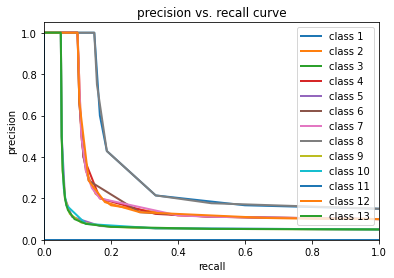

In [ ]:
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
Y_in_bin = label_binarize(Y_in, classes=[x for x in range(1,14)])
n_classes = Y_in_bin.shape[1]

clf = OneVsRestClassifier(MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None))
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)

# precision recall curve
probability_thresholds = np.linspace(0, 1, num=100)

precision_scores = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}
recall_scores = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}
for i in range(n_classes):
    y_test_true = []
    for y in y_test:
      if y == i+1: y_test_true.append(1)
      else: y_test_true.append(0)

    for p in probability_thresholds:

      y_test_preds = []
      y_test_probs = y_score[:,i]
      for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
      
      # print(y_test_tmp, y_test_preds)
      precision, recall = calc_precision_recall(y_test_true, y_test_preds)
      precision_scores[i].append(precision)
      recall_scores[i].append(recall)

    plt.plot(recall_scores[i], precision_scores[i], lw=2, label='class {}'.format(i+1))
    
print(y_test_true)
print(y_test_probs)
print(precision_scores[12])
print(recall_scores[12])

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("precision vs. recall curve")
plt.show()


[[0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [1], [0], [0]]
[[0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [1], [0], [0], [0]]
[[0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0]]
[[1], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


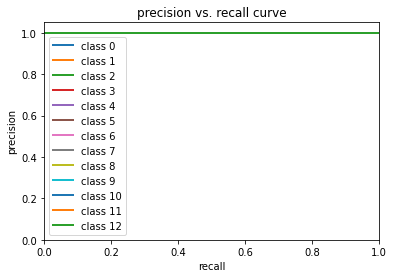

In [ ]:
precision = dict()
recall = dict()
# print(y_test)
# print(y_score)

for i in range(n_classes):
  y_test_tmp = []
  for y in y_test:
    if int(y) == i+1:
      y_test_tmp.append([1])
    else:
      y_test_tmp.append([0])

  print(y_test_tmp)
  # print(y_score[:,i])
  precision[i], recall[i], _ = precision_recall_curve(y_test_tmp, y_score[:, i])
  plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [ ]:
print(metrics.classification_report(predicted_results, y_test))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       1.00      1.00      1.00         2
         3.0       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         2
         5.0       1.00      1.00      1.00         1
         6.0       0.50      1.00      0.67         1
         7.0       1.00      1.00      1.00         2
         8.0       1.00      1.00      1.00         3
         9.0       1.00      1.00      1.00         1
        10.0       1.00      1.00      1.00         1
        12.0       1.00      1.00      1.00         2
        13.0       1.00      1.00      1.00         1

    accuracy                           0.95        20
   macro avg       0.88      0.92      0.89        20
weighted avg       0.93      0.95      0.93        20



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM Linear model

In [ ]:
from sklearn.svm import SVC

In [ ]:
svmlin_model = SVC(kernel='linear', C=1.0)
svmlin_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predicted_results = []
predicted_results.extend(svmlin_model.predict(X_test))
print(predicted_results)

scores = cross_val_score(svmlin_model, X_in, Y_in, cv=10, scoring='f1_micro')
print(scores.mean())

print(metrics.confusion_matrix(y_test, predicted_results))

# out of sample prediction
out_predicted_results = []
out_predicted_results.extend(svmlin_model.predict(X_out))

[8.0, 6.0, 1.0, 6.0, 2.0, 5.0, 13.0, 8.0, 7.0, 8.0, 12.0, 12.0, 1.0, 4.0, 2.0, 10.0, 4.0, 1.0, 7.0, 9.0]
0.9894736842105264
[[3 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 1]]


[[0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [1], [0], [0]]
[[0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [1], [0], [0], [0]]
[[0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0]]
[[1], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


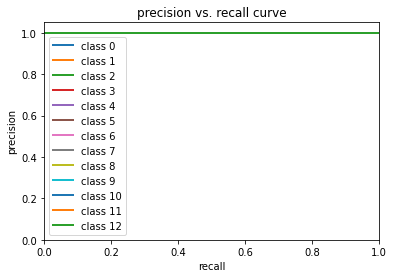

In [ ]:
precision = dict()
recall = dict()
# print(y_test)
# print(y_score)

for i in range(n_classes):
  y_test_tmp = []
  for y in y_test:
    if int(y) == i+1:
      y_test_tmp.append([1])
    else:
      y_test_tmp.append([0])

  print(y_test_tmp)
  # print(y_score[:,i])
  precision[i], recall[i], _ = precision_recall_curve(y_test_tmp, y_score[:, i])
  plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [ ]:
print(metrics.classification_report(predicted_results, y_test))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       1.00      1.00      1.00         2
         4.0       1.00      1.00      1.00         2
         5.0       1.00      1.00      1.00         1
         6.0       1.00      1.00      1.00         2
         7.0       1.00      1.00      1.00         2
         8.0       1.00      1.00      1.00         3
         9.0       1.00      1.00      1.00         1
        10.0       1.00      1.00      1.00         1
        12.0       1.00      1.00      1.00         2
        13.0       1.00      1.00      1.00         1

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



# SVM Rbf

In [ ]:
svmrbf_model = SVC(kernel='rbf', C=1.0)
svmrbf_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predicted_results = []
predicted_results.extend(svmrbf_model.predict(X_test))
print(predicted_results)

scores = cross_val_score(svmrbf_model, X_in, Y_in, cv=10, scoring='f1_micro')
print(scores.mean())

print(metrics.confusion_matrix(y_test, predicted_results))

# out of sample prediction
out_predicted_results = []
out_predicted_results.extend(svmrbf_model.predict(X_out))

[8.0, 6.0, 1.0, 6.0, 2.0, 5.0, 13.0, 8.0, 7.0, 8.0, 12.0, 12.0, 1.0, 4.0, 2.0, 10.0, 4.0, 1.0, 7.0, 9.0]
0.9697368421052632
[[3 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 1]]


[[0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [1], [0], [0]]
[[0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [1], [0], [0], [0]]
[[0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0]]
[[1], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


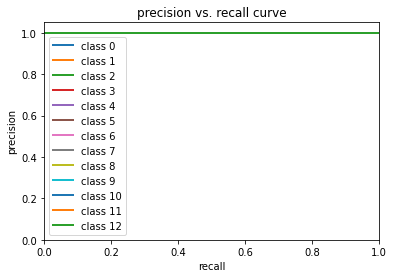

In [ ]:
precision = dict()
recall = dict()
# print(y_test)
# print(y_score)

for i in range(n_classes):
  y_test_tmp = []
  for y in y_test:
    if int(y) == i+1:
      y_test_tmp.append([1])
    else:
      y_test_tmp.append([0])

  print(y_test_tmp)
  # print(y_score[:,i])
  precision[i], recall[i], _ = precision_recall_curve(y_test_tmp, y_score[:, i])
  plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [ ]:
print(metrics.classification_report(predicted_results, y_test))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       1.00      1.00      1.00         2
         4.0       1.00      1.00      1.00         2
         5.0       1.00      1.00      1.00         1
         6.0       1.00      1.00      1.00         2
         7.0       1.00      1.00      1.00         2
         8.0       1.00      1.00      1.00         3
         9.0       1.00      1.00      1.00         1
        10.0       1.00      1.00      1.00         1
        12.0       1.00      1.00      1.00         2
        13.0       1.00      1.00      1.00         1

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

